# ML Options Pricing Model

### This notebook replicates the functionality of `main.py` while adding visualizations, statistical comparisons, and regression analysis.

In [43]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy.interpolate import griddata

In [44]:
from data_loader import get_options_chain, parse_options_chain
from volatility_model import VolatilityModel
from pricing_model import PricingModel
from signal_generator import SignalGenerator

In [45]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Calculate historical volatility using GARCH

In [46]:
ticker = 'AAPL'

In [47]:
options_json = get_options_chain(ticker)
options_json

INFO:Schwabdev:Access token expires in 00H:07M:38S
INFO:Schwabdev:Refresh token expires in 167H:08M:27S
INFO:Schwabdev:Client Initialization Complete


{'symbol': 'AAPL',
 'status': 'SUCCESS',
 'underlying': {'symbol': 'AAPL',
  'description': 'APPLE INC',
  'change': -4.95,
  'percentChange': -2.01,
  'close': 247.04,
  'quoteTime': 1740586900422,
  'tradeTime': 1740586899951,
  'bid': 242.07,
  'ask': 242.1,
  'last': 242.09,
  'mark': 242.09,
  'markChange': -4.95,
  'markPercentChange': -2.01,
  'bidSize': 2,
  'askSize': 6,
  'highPrice': 244.98,
  'lowPrice': 241.42,
  'openPrice': 244.33,
  'totalVolume': 16213165,
  'exchangeName': 'NASDAQ',
  'fiftyTwoWeekHigh': 260.1,
  'fiftyTwoWeekLow': 164.08,
  'delayed': False},
 'strategy': 'SINGLE',
 'interval': 0.0,
 'isDelayed': False,
 'isIndex': False,
 'interestRate': 4.738,
 'underlyingPrice': 242.08499999999998,
 'volatility': 29.0,
 'daysToExpiration': 0.0,
 'dividendYield': 0.0,
 'numberOfContracts': 1141,
 'assetMainType': 'EQUITY',
 'assetSubType': 'COE',
 'isChainTruncated': False,
 'callExpDateMap': {'2025-02-28:2': {'242.5': [{'putCall': 'CALL',
     'symbol': 'AAPL  250

In [48]:
options = parse_options_chain(options_json)

In [49]:
stock_data = yf.download(ticker, period="5y")

[*********************100%***********************]  1 of 1 completed


In [50]:
# get the interest rate from an api 10 year treasury yield
interest_rate = yf.Ticker("^TNX").history(period="1d")["Close"].iloc[-1]

In [51]:
print("Options Chain:")
print(options.head())

Options Chain:
   strikePrice expirationDate putCall   bid   ask  mark  volatility  delta  \
0        242.5     2025-02-28    CALL  2.12  2.14  2.13      29.846  0.487   
1        245.0     2025-02-28    CALL  1.09  1.10  1.10      28.935  0.315   
2        247.5     2025-02-28    CALL  0.51  0.52  0.52      28.716  0.176   
3        250.0     2025-02-28    CALL  0.22  0.23  0.23      29.180  0.088   
4        252.5     2025-02-28    CALL  0.10  0.11  0.11      30.522  0.044   

   gamma  theta   vega    rho  openInterest  timeValue  \
0  0.070 -0.589  0.076  0.007          2655       2.16   
1  0.064 -0.483  0.068  0.005         19602       1.10   
2  0.047 -0.312  0.050  0.003         13896       0.52   
3  0.029 -0.169  0.031  0.001         23519       0.22   
4  0.016 -0.088  0.018  0.001         27494       0.11   

   theoreticalOptionValue  ImpliedVolatility  daysToExpiration  inTheMoney  
0                   2.160               29.0                 2       False  
1            

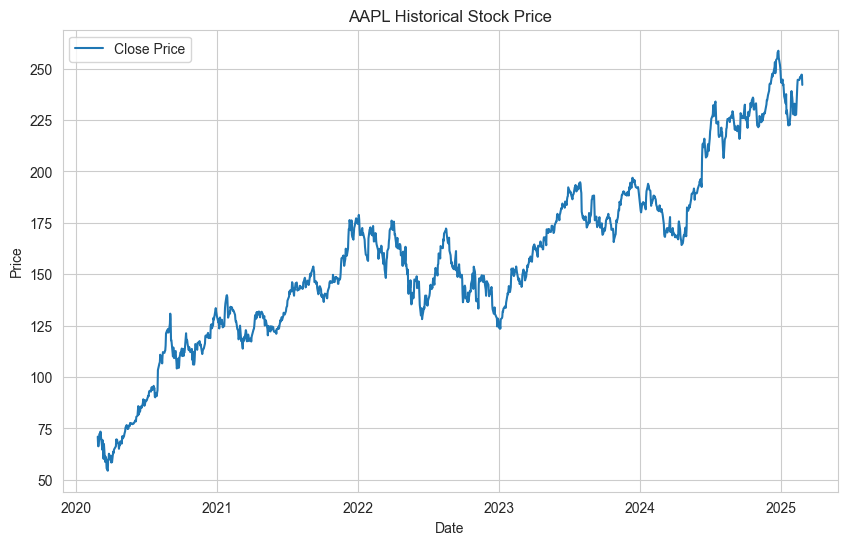

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Close Price')
plt.title(f"{ticker} Historical Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [53]:
stock_data['LogReturn'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data.dropna(inplace=True)

In [54]:
stock_data['LogReturn'] *= 100

In [55]:
garch_model = arch_model(stock_data['LogReturn'], vol='Garch', p=1, q=1)
garch_model_fit = garch_model.fit(disp='off')

In [56]:
print(garch_model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2494.06
Distribution:                  Normal   AIC:                           4996.12
Method:            Maximum Likelihood   BIC:                           5016.67
                                        No. Observations:                 1257
Date:                Wed, Feb 26 2025   Df Residuals:                     1256
Time:                        11:21:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1246  4.897e-02      2.544  1.097e-02 [2.858e-0

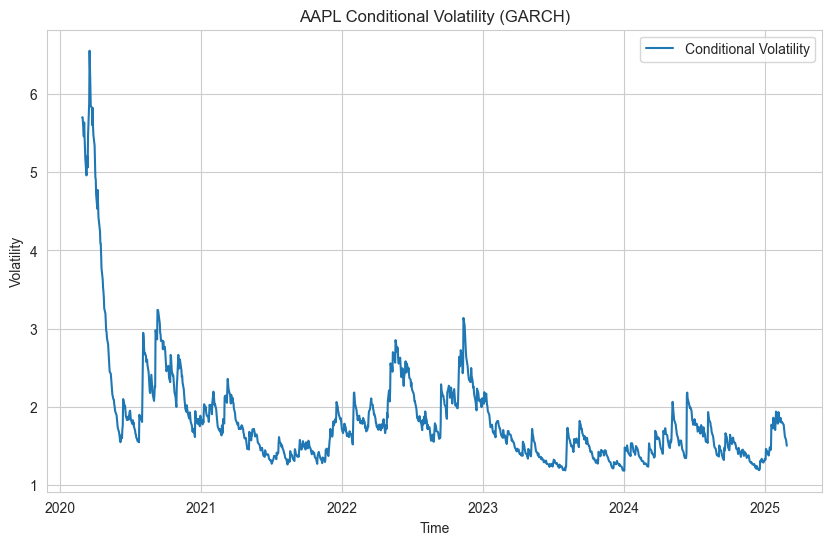

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(garch_model_fit.conditional_volatility, label='Conditional Volatility')
plt.title(f"{ticker} Conditional Volatility (GARCH)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [58]:
underlying_price = stock_data['Close'].iloc[-1]
risk_free_rate = interest_rate / 100

In [59]:
volModel = VolatilityModel(options_chain_df=options, underlying_price=underlying_price, risk_free_rate=risk_free_rate)
historical_volatility = garch_model_fit.conditional_volatility

In [60]:
options['ImpliedVolatility'] = options.apply(
    lambda row: volModel.calculate_implied_volatility(
        option_price=row['mark'],
        strike=row['strikePrice'],
        expiration_days=row['daysToExpiration'],
        option_type=row['putCall'],  # 'CALL' or 'PUT'
    ),
    axis=1
)

In [61]:
# Display the first few rows of the options chain with implied volatilities
print("Options Chain with Implied Volatilities:")
print(options.head())

Options Chain with Implied Volatilities:
   strikePrice expirationDate putCall   bid   ask  mark  volatility  delta  \
0        242.5     2025-02-28    CALL  2.12  2.14  2.13      29.846  0.487   
1        245.0     2025-02-28    CALL  1.09  1.10  1.10      28.935  0.315   
2        247.5     2025-02-28    CALL  0.51  0.52  0.52      28.716  0.176   
3        250.0     2025-02-28    CALL  0.22  0.23  0.23      29.180  0.088   
4        252.5     2025-02-28    CALL  0.10  0.11  0.11      30.522  0.044   

   gamma  theta   vega    rho  openInterest  timeValue  \
0  0.070 -0.589  0.076  0.007          2655       2.16   
1  0.064 -0.483  0.068  0.005         19602       1.10   
2  0.047 -0.312  0.050  0.003         13896       0.52   
3  0.029 -0.169  0.031  0.001         23519       0.22   
4  0.016 -0.088  0.018  0.001         27494       0.11   

   theoreticalOptionValue  ImpliedVolatility  daysToExpiration  inTheMoney  
0                   2.160           0.274190                 2  

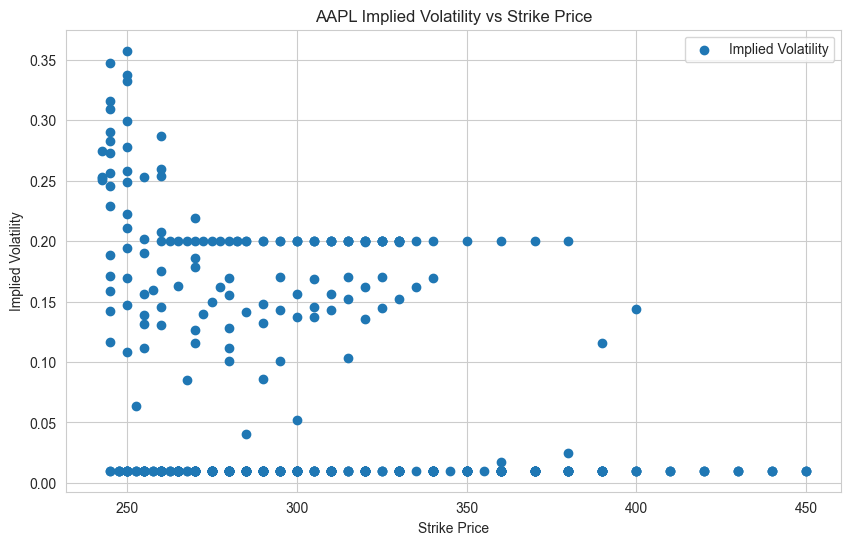

In [62]:
# Plot implied volatility vs strike price
plt.figure(figsize=(10, 6))
plt.scatter(options['strikePrice'], options['ImpliedVolatility'], label='Implied Volatility')
plt.title(f"{ticker} Implied Volatility vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [63]:
strikes = options['strikePrice'].values
expirations = options['daysToExpiration'].values
implied_vols = options['ImpliedVolatility'].values

In [64]:
grid_strikes, grid_expirations = np.meshgrid(
    np.linspace(strikes.min(), strikes.max(), 100),
    np.linspace(expirations.min(), expirations.max(), 100)
)

In [65]:
# Add small noise to strikes and expirations
noise_level = 1e-5  # Adjust this value as needed
strikes = options['strikePrice'].values + np.random.normal(0, noise_level, size=len(options))
expirations = options['daysToExpiration'].values + np.random.normal(0, noise_level, size=len(options))
implied_vols = options['ImpliedVolatility'].values

# Create a grid for interpolation
grid_strikes, grid_expirations = np.meshgrid(
    np.linspace(strikes.min(), strikes.max(), 100),
    np.linspace(expirations.min(), expirations.max(), 100)
)

# Interpolate using cubic spline
volatility_surface = griddata(
    (strikes, expirations), implied_vols,
    (grid_strikes, grid_expirations), method='cubic'
)

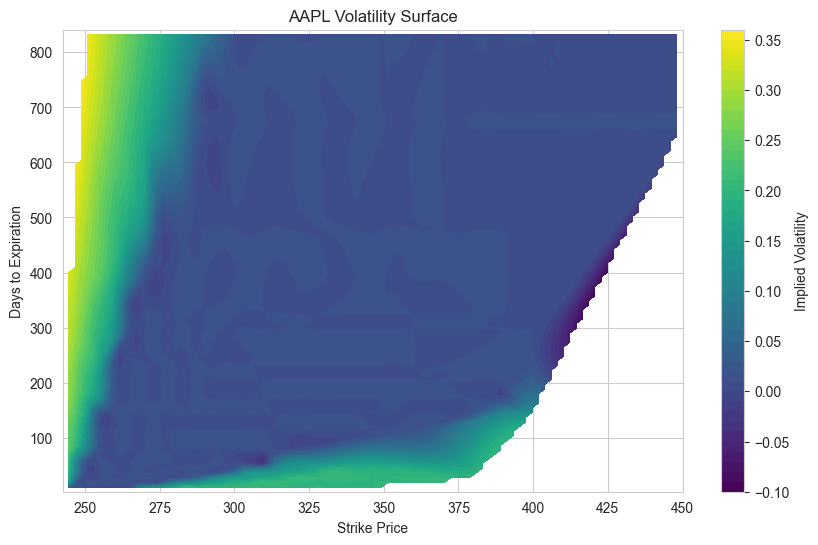

In [66]:
plt.figure(figsize=(10, 6))
plt.contourf(grid_strikes, grid_expirations, volatility_surface, levels=50, cmap='viridis')
plt.colorbar(label='Implied Volatility')
plt.title(f"{ticker} Volatility Surface")
plt.xlabel("Strike Price")
plt.ylabel("Days to Expiration")
plt.show()

In [67]:
underlying_price = stock_data['Close'].iloc[-1]
options['Moneyness'] = underlying_price[0] / options['strikePrice']
options['TimeToExpiration'] = options['daysToExpiration'] / 365
options['RiskFreeRate'] = interest_rate / 100
options['HistoricalVolatility'] = garch_model_fit.conditional_volatility[-1] / 100

In [68]:
print("Options Chain with Features:")
print(options.head())

Options Chain with Features:
   strikePrice expirationDate putCall   bid   ask  mark  volatility  delta  \
0        242.5     2025-02-28    CALL  2.12  2.14  2.13      29.846  0.487   
1        245.0     2025-02-28    CALL  1.09  1.10  1.10      28.935  0.315   
2        247.5     2025-02-28    CALL  0.51  0.52  0.52      28.716  0.176   
3        250.0     2025-02-28    CALL  0.22  0.23  0.23      29.180  0.088   
4        252.5     2025-02-28    CALL  0.10  0.11  0.11      30.522  0.044   

   gamma  theta  ...  openInterest  timeValue  theoreticalOptionValue  \
0  0.070 -0.589  ...          2655       2.16                   2.160   
1  0.064 -0.483  ...         19602       1.10                   1.115   
2  0.047 -0.312  ...         13896       0.52                   0.515   
3  0.029 -0.169  ...         23519       0.22                   0.225   
4  0.016 -0.088  ...         27494       0.11                   0.105   

   ImpliedVolatility  daysToExpiration  inTheMoney  Moneyness  

### Train the XGBoost model

In [69]:
pricing_model = PricingModel()
pricing_model.train_xgboost_model(options, underlying_price[0], interest_rate/100, historical_volatility[0])

Validation Mean Squared Error: 0.000373
Validation Root Mean Squared Error: 0.019309
Validation R² Score: 0.953838


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [70]:
predicted_chain = pricing_model.predict_option_chain(
    stock_price=stock_data['Close'].iloc[-1],
    options_chain=options,
    interest_rate=interest_rate,
    historical_volatility=historical_volatility.iloc[-1]
)

In [71]:
print("Predicted Option Chain:")
print(predicted_chain.head())

Predicted Option Chain:
   strikePrice expirationDate putCall   bid   ask  mark  marketVolatility  \
0        242.5     2025-02-28    CALL  2.12  2.14  2.13          0.274190   
1        245.0     2025-02-28    CALL  1.09  1.10  1.10          0.010000   
2        247.5     2025-02-28    CALL  0.51  0.52  0.52          0.010000   
3        250.0     2025-02-28    CALL  0.22  0.23  0.23          0.010000   
4        252.5     2025-02-28    CALL  0.10  0.11  0.11          0.063422   

   predictedVolatility                                     predictedPrice  \
0             0.227942  Ticker
AAPL    1.472169
Name: 2025-02-26 00:00...   
1             0.202510  Ticker
AAPL    0.458905
Name: 2025-02-26 00:00...   
2             0.150221  Ticker
AAPL    0.025909
Name: 2025-02-26 00:00...   
3             0.097277  Ticker
AAPL    0.000002
Name: 2025-02-26 00:00...   
4             0.102253  Ticker
AAPL    5.497576e-09
Name: 2025-02-26 0...   

          delta                                   

### Trading Signals

In [72]:
signal_generator = SignalGenerator()
signals = signal_generator.generate_trading_signals(predicted_chain)

In [73]:
print("\nTrading Signals:")
print(signal_generator.format_output(signals))


Trading Signals:
Option: CALL 242.5 Expiring in 2 days (2025-02-28)
Market Price: $2.13, Predicted Price: $1.47, Difference: -30.88%
Market IV: 27.42%, Predicted IV: 22.79%, Difference: -16.87%
Signal: Strong Sell
Explanation: Model predicts price is 30.88% lower than market. Market is overestimating volatility by 16.87%.
Greeks - Delta: 0.4714, Gamma: 0.0974, Theta: -0.4197, Vega: 0.0713, Rho: 0.0062
In The Money: False
--------------------------------------------------
Option: CALL 245.0 Expiring in 2 days (2025-02-28)
Market Price: $1.10, Predicted Price: $0.46, Difference: -58.28%
Market IV: 1.00%, Predicted IV: 20.25%, Difference: +1925.10%
Signal: Strong Sell
Explanation: Model predicts price is 58.28% lower than market. Market price is too high despite higher predicted volatility.
Greeks - Delta: 0.2215, Gamma: 0.0819, Theta: -0.2760, Vega: 0.0533, Rho: 0.0029
In The Money: False
--------------------------------------------------
Option: CALL 247.5 Expiring in 2 days (2025-02-2

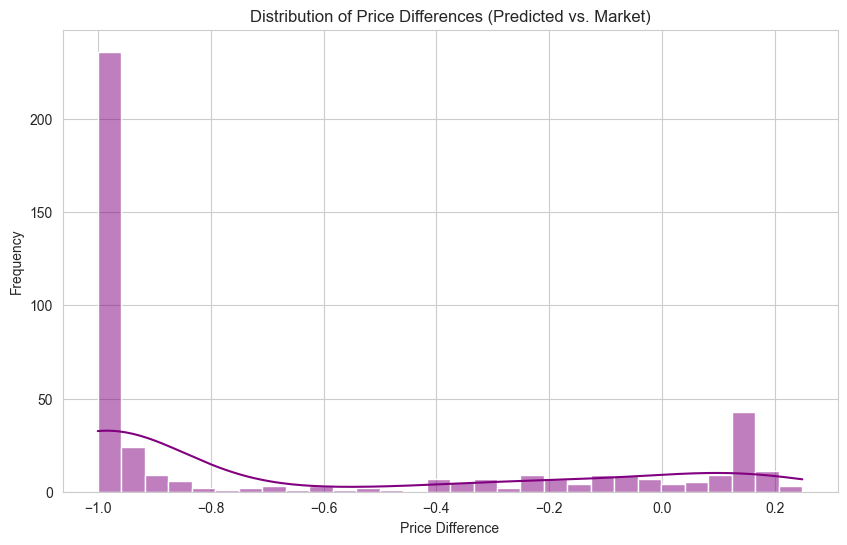

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(signals['priceDifference'], bins=30, kde=True, color="purple")
plt.title("Distribution of Price Differences (Predicted vs. Market)")
plt.xlabel("Price Difference")
plt.ylabel("Frequency")
plt.show()

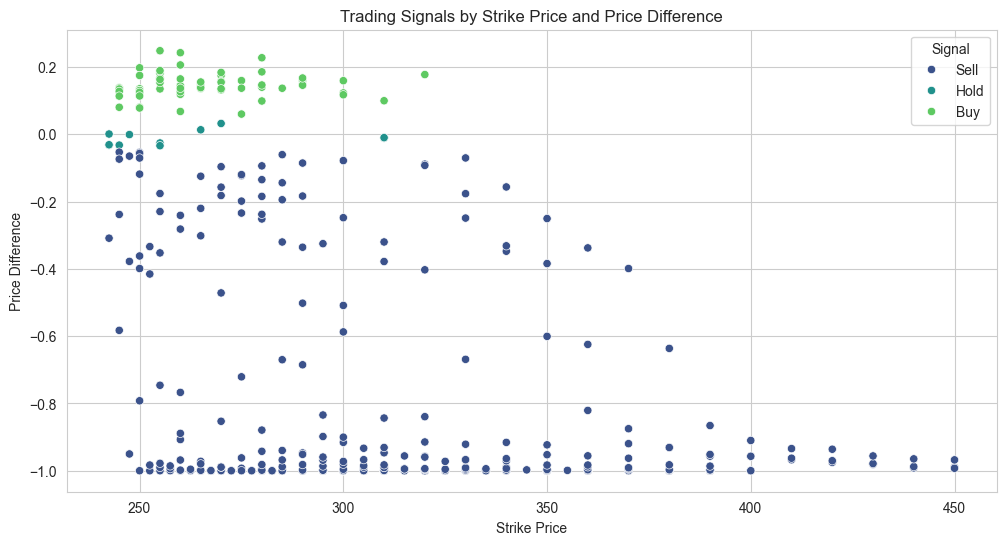

In [75]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="strikePrice", y="priceDifference", hue="signal", data=signals, palette="viridis")
plt.title("Trading Signals by Strike Price and Price Difference")
plt.xlabel("Strike Price")
plt.ylabel("Price Difference")
plt.legend(title="Signal")
plt.show()